In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook  
%matplotlib inline 
from astropy import units as u
from astropy import table as Table
from astropy.io import ascii
from dust_extinction.dust_extinction import F99

In [2]:
from astropy.modeling import blackbody as blackbody
import scipy.interpolate as interp

In [3]:
data1 = ascii.read('AATau_IR2008.txt')
data2 = ascii.read('AATau_opt2008.txt')
data = Table.vstack([data2, data1])
allwav_2008=data['wavelength']
alldata_2008=data['flux']

data1 = ascii.read('AATau_IR2014dec02.txt')
data2 = ascii.read('AATau_opt2014dec02.txt')
data = Table.vstack([data2, data1])
allwav_dec02=data['wavelength']
alldata_dec02=data['flux']

data1 = ascii.read('AATau_IR2014dec12.txt')
data2 = ascii.read('AATau_opt2014dec12.txt')
data = Table.vstack([data2, data1])
allwav_dec12=data['wavelength']
alldata_dec12=data['flux']

In [5]:
# Mask out telluric:
alldata_2008[alldata_2008>1E-13*alldata_2008.unit]=0
alldata_dec02[alldata_dec02>1E-13*alldata_2008.unit]=0
alldata_dec12[alldata_dec12>1E-13*alldata_2008.unit]=0
alldata_2008[alldata_2008<0*alldata_2008.unit]=0
alldata_dec02[alldata_dec02<0*alldata_2008.unit]=0
alldata_dec12[alldata_dec12<0*alldata_2008.unit]=0

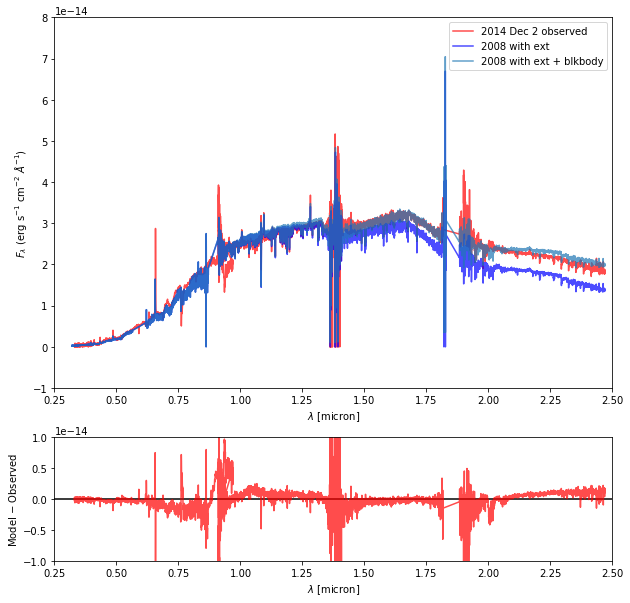

In [6]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10),gridspec_kw = {'height_ratios':[3, 1]})

Rv = 3.0
Av = 2.2
ext = F99(Rv=Rv)

# ax1.plot(allwav_2008,alldata_2008,'grey',label='2008 observed')
ax1.plot(allwav_dec02,alldata_dec02,'red',label='2014 Dec 2 observed',alpha=0.7)

ext2008=alldata_2008*ext.extinguish(allwav_2008,Av=Av)
ax1.plot(allwav_2008,ext2008,'blue',label='2008 with ext',alpha=0.7)
ax1.plot(allwav_2008,ext2008 + (10.**-16.8*u.sr*blackbody.blackbody_lambda(allwav_2008,1000*u.K)),
         label='2008 with ext + blkbody',alpha=0.7)

# The free parameters are:  Av, Rv, BBscale, temp

ax1.set_ylim(-0.1E-13,0.8E-13)
ax1.set_xlim(0.25,2.5)
ax1.set_xlabel('$\lambda$ [micron]')
ax1.set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax1.legend(loc='upper right')

interp2008=interp.interp1d(allwav_2008,alldata_2008)

ax2.plot([.25,2.5],[0,0],'k')
ax2.plot(allwav_dec02,
         interp2008(allwav_dec02)*alldata_2008.unit*ext.extinguish(allwav_dec02,Av=Av)
          +(0.15E-16*u.sr*blackbody.blackbody_lambda(allwav_dec02,1000*u.K))
          -alldata_dec02,'r',alpha=0.7)
ax2.set_xlim(0.25,2.5)
ax2.set_ylim(-1E-14,1E-14)
ax2.set_xlabel('$\lambda$ [micron]')
ax2.set_ylabel('Model $-$ Observed')

plt.show()

In [7]:
from scipy.optimize import leastsq,least_squares

In [8]:
def fitAATau(coeffs,allwav_2008,alldata_2008,allwav_dec02,alldata_dec02):

    # The free parameters are:  Av, Rv, BBscale, temp
    Av=2.1
    Rv=3.0
    scale=coeffs[0]
    temp=coeffs[1]
    
    ext = F99(Rv=3.0)

    interp2008=interp.interp1d(allwav_2008,alldata_2008)

    model=interp2008(allwav_dec02)*alldata_dec02.unit*ext.extinguish(allwav_dec02,Av=Av)+((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_dec02,temp*u.K)/(temp**4))

    return 1.E18*np.sum((model.value-alldata_dec02.value)**2)

In [9]:
x0=np.array([-20.,1000.])
bnds=((-200.,0.),(-1.,10000.))

result=least_squares(fitAATau, x0, 
        args=(allwav_2008,alldata_2008,allwav_dec02,alldata_dec02), 
        bounds=bnds)

In [10]:
result

 active_mask: array([0, 0])
        cost: 3.968227736239276e-15
         fun: array([8.90867862e-08])
        grad: array([-3.86332437e-16, -1.63925041e-18])
         jac: array([[-4.33658518e-09, -1.84006010e-11]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 1
        njev: 1
  optimality: 1.4753253696751043e-14
      status: 1
     success: True
           x: array([ -20., 1000.])

In [11]:
x=result.x
# x=np.array([2,-55,1000])

NameError: name 'x' is not defined

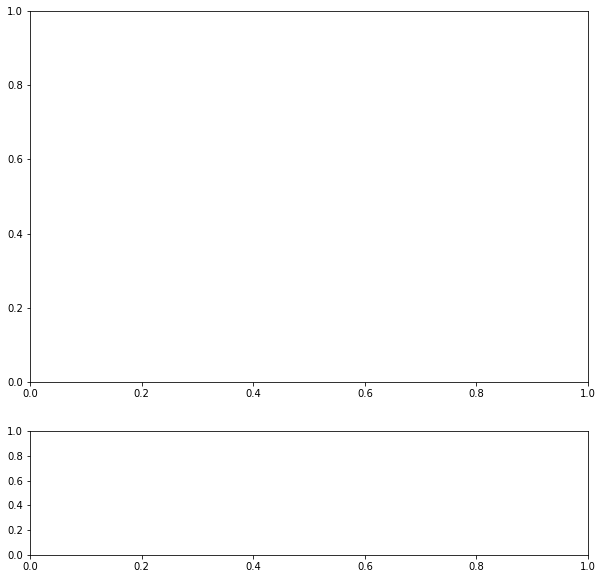

In [8]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10),gridspec_kw = {'height_ratios':[3, 1]})

Rv = 3.0
Av = 2.0
scale=x[0]
temp=x[1]
ext = F99(Rv=Rv)

# ax1.plot(allwav_2008,alldata_2008,'grey',label='2008 observed')
ax1.plot(allwav_dec02,alldata_dec02,'red',label='2014 Dec 2 observed',alpha=0.7)

ext2008=alldata_2008*ext.extinguish(allwav_2008,Av=Av)
ax1.plot(allwav_2008,ext2008,'blue',label='2008 with ext',alpha=0.7)
ax1.plot(allwav_2008,ext2008 + ((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_2008,temp*u.K)/temp**4),
         'k',label='2008 with ext + blkbody')

# The free parameters are:  Av, Rv, BBscale, temp

ax1.set_ylim(-0.1E-13,0.8E-13)
ax1.set_xlim(0.25,2.5)
ax1.set_xlabel('$\lambda$ [micron]')
ax1.set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax1.legend(loc='upper right')

interp2008=interp.interp1d(allwav_2008,alldata_2008)

ax2.plot([.25,2.5],[0,0],'k')
# ax2.plot(allwav_dec02,
#          interp2008(allwav_dec02)*alldata_2008.unit*ext.extinguish(allwav_dec02,Av=Av)
#           +(0.15E-16*u.sr*blackbody.blackbody_lambda(allwav_dec02,1000*u.K))
#           -alldata_dec02,'r',alpha=0.7)
ax2.set_xlim(0.25,2.5)
ax2.set_ylim(-1E-14,1E-14)
ax2.set_xlabel('$\lambda$ [micron]')
ax2.set_ylabel('Model $-$ Observed')

plt.show()

In [13]:
xrange=np.arange(-17,-15,0.1)
yrange=np.arange(500,1400,20)
xgrid,ygrid=np.meshgrid(xrange,yrange)

out=xgrid*0.0

for i,x in enumerate(xrange):
    for j,y in enumerate(yrange):
        Av=2.3
        scale=x
        temp=y
        model=interp2008(allwav_dec02)*alldata_dec02.unit*ext.extinguish(allwav_dec02,Av=Av)+((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_dec02,temp*u.K)/(temp**4))
        out[j,i]=1.E18*np.sum((model.value-alldata_dec02.value)**2)


C:\Users\kris\Anaconda3\lib\site-packages\astropy\units\quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


C:\Users\kris\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


IndexError: index 2 is out of bounds for size 2

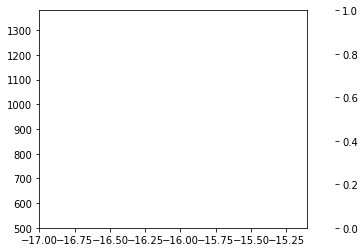

In [14]:
plt.contour(xgrid,ygrid,out,levels=np.linspace(4E-8,1E-7))
plt.colorbar()

In [15]:
outminy,outminx=np.where(out==out.min())
# y first, then x

In [16]:
xrange[outminx[0]],yrange[outminy[0]],out.min()


(-17.0, 500, 1.6050341899035354e-07)

1.9 (-15.7, 860, 7.307204362775906e-08)

2.0 (-15.9, 920, 5.788387713183714e-08)

2.1 (-16.2, 1000, 4.8551801405544304e-08)

2.2 (-16.4, 1080, 4.4139912976282534e-08)

2.3 (-16.6, 1200, 4.3504183509016296e-08)

C:\Users\kris\Anaconda3\lib\site-packages\astropy\units\quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


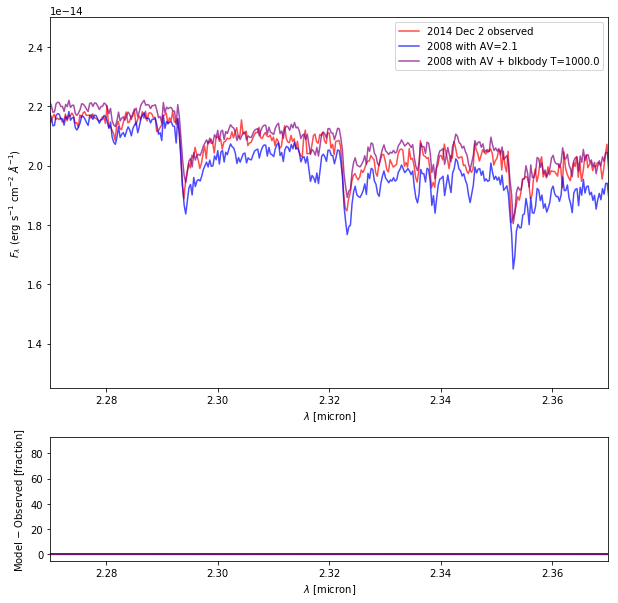

In [15]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10),gridspec_kw = {'height_ratios':[3, 1]})

Av = 2.1
scale=-16.3
temp=1000.

# ax1.plot(allwav_2008,alldata_2008,'grey',label='2008 observed')
ax1.plot(allwav_dec02,alldata_dec02,'red',label='2014 Dec 2 observed',alpha=0.7)

ext2008=alldata_2008*ext.extinguish(allwav_2008,Av=Av)
ax1.plot(allwav_2008,ext2008*2.2/1.8,'blue',label='2008 with AV='+str(Av),alpha=0.7) # KAL FIX THIS BACK
ax1.plot(allwav_2008,ext2008 + ((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_2008,temp*u.K)/temp**4),
         'purple',label='2008 with AV + blkbody T='+str(temp),alpha=0.7)

# The free parameters are:  Av, Rv, BBscale, temp

# ax1.set_ylim(0,0.4E-13)
ax1.set_ylim(1.25E-14,2.5E-14)
# ax1.set_xlim(0.25,2.5)
ax1.set_xlim(2.27,2.37)
ax1.set_xlabel('$\lambda$ [micron]')
ax1.set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax1.legend(loc='best')

interp2008=interp.interp1d(allwav_2008,alldata_2008)

ax2.plot([.25,2.5],[0,0],'k')
ax2.plot(allwav_dec02,
         (interp2008(allwav_dec02)*alldata_2008.unit*ext.extinguish(allwav_dec02,Av=Av)
          +((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_dec02,temp*u.K)/temp**4)
          -alldata_dec02)/alldata_dec02,'purple',alpha=0.7)
# ax2.set_xlim(0.25,2.5)
ax2.set_xlim(2.27,2.37)
# ax2.set_ylim(-.2,.2)
ax2.set_xlabel('$\lambda$ [micron]')
ax2.set_ylabel('Model $-$ Observed [fraction]')

plt.show()

C:\Users\kris\Anaconda3\lib\site-packages\astropy\units\quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


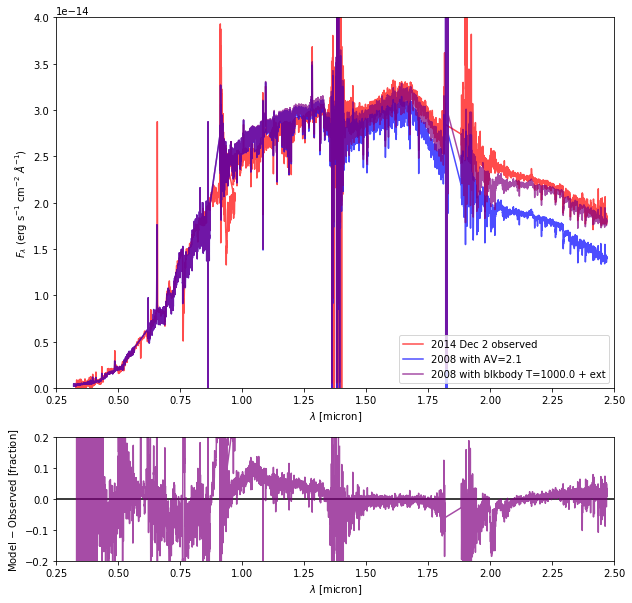

In [25]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10),gridspec_kw = {'height_ratios':[3, 1]})

Av = 2.1
scale=-16.3
temp=1000.

# ax1.plot(allwav_2008,alldata_2008,'grey',label='2008 observed')
ax1.plot(allwav_dec02,alldata_dec02,'red',label='2014 Dec 2 observed',alpha=0.7)

ext2008=alldata_2008*ext.extinguish(allwav_2008,Av=Av)
ax1.plot(allwav_2008,ext2008,'blue',label='2008 with AV='+str(Av),alpha=0.7)
ax1.plot(allwav_2008,(alldata_2008 + ((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_2008,temp*u.K)/temp**4))*ext.extinguish(allwav_2008,Av=Av),
         'purple',label='2008 with blkbody T='+str(temp)+' + ext',alpha=0.7)

# The free parameters are:  Av, Rv, BBscale, temp

ax1.set_ylim(0,0.4E-13)
ax1.set_xlim(0.25,2.5)
ax1.set_xlabel('$\lambda$ [micron]')
ax1.set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax1.legend(loc='best')

interp2008=interp.interp1d(allwav_2008,alldata_2008)

ax2.plot([.25,2.5],[0,0],'k')
ax2.plot(allwav_dec02,
         (interp2008(allwav_dec02)*alldata_2008.unit*ext.extinguish(allwav_dec02,Av=Av)
          +((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_dec02,temp*u.K)/temp**4)
          -alldata_dec02)/alldata_dec02,'purple',alpha=0.7)
ax2.set_xlim(0.25,2.5)
ax2.set_ylim(-0.2,0.2)
ax2.set_xlabel('$\lambda$ [micron]')
ax2.set_ylabel('Model $-$ Observed [fraction]')

plt.show()

C:\Users\kris\Anaconda3\lib\site-packages\astropy\units\quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


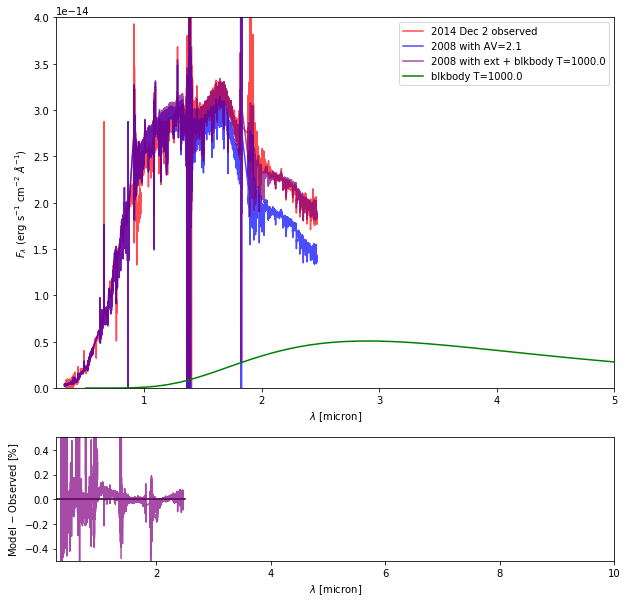

In [18]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10),gridspec_kw = {'height_ratios':[3, 1]})

Av = 2.1
scale=-16.3
temp=1000.

# ax1.plot(allwav_2008,alldata_2008,'grey',label='2008 observed')
ax1.plot(allwav_dec02,alldata_dec02,'red',label='2014 Dec 2 observed',alpha=0.7)

ext2008=alldata_2008*ext.extinguish(allwav_2008,Av=Av)
ax1.plot(allwav_2008,ext2008,'blue',label='2008 with AV='+str(Av),alpha=0.7)
ax1.plot(allwav_2008,ext2008 + ((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_2008,temp*u.K)/temp**4),
         'purple',label='2008 with ext + blkbody T='+str(temp),alpha=0.7)
bbextend=np.arange(0.5,10.,0.1)*u.micron
ax1.plot(bbextend,((2.**scale)*u.sr*blackbody.blackbody_lambda(bbextend,temp*u.K)/temp**4),'green',label='blkbody T='+str(temp))

# The free parameters are:  Av, Rv, BBscale, temp

ax1.set_ylim(0,0.4E-13)
ax1.set_xlim(0.25,5.)
ax1.set_xlabel('$\lambda$ [micron]')
ax1.set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax1.legend(loc='upper right')

interp2008=interp.interp1d(allwav_2008,alldata_2008)

ax2.plot([.25,2.5],[0,0],'k')
ax2.plot(allwav_dec02,
         (interp2008(allwav_dec02)*alldata_2008.unit*ext.extinguish(allwav_dec02,Av=Av)
          +((2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_dec02,temp*u.K)/temp**4)
          -alldata_dec02)/alldata_dec02,'purple',alpha=0.7)
ax2.set_xlim(0.25,10.0)
ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel('$\lambda$ [micron]')
ax2.set_ylabel('Model $-$ Observed [%]')

plt.show()

C:\Users\kris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\kris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
C:\Users\kris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\kris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


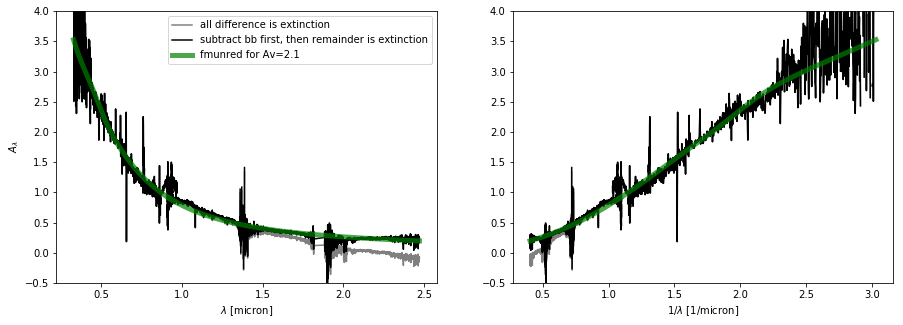

In [19]:
ext_dec02=-2.5*np.log10(alldata_dec02.value/interp2008(allwav_dec02))

bb=(2.**scale)*u.sr*blackbody.blackbody_lambda(allwav_dec02,temp*u.K)/temp**4
ext_dec02_bb=-2.5*np.log10((alldata_dec02.value-bb.value)/interp2008(allwav_dec02))


fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(allwav_dec02,ext_dec02,'grey',label='all difference is extinction')
ax2.plot(1./allwav_dec02,ext_dec02,'grey')

ax1.plot(allwav_dec02,ext_dec02_bb,'k',label='subtract bb first, then remainder is extinction')
ax2.plot(1./allwav_dec02,ext_dec02_bb,'k')

ax1.plot(allwav_dec02,Av*ext(allwav_dec02),'green',linewidth=5,alpha=0.7,label='fmunred for Av='+str(Av))
ax2.plot(1/allwav_dec02,Av*ext(allwav_dec02),'green',linewidth=5,alpha=0.7)

ax1.set_xlabel('$\lambda$ [micron]')
ax2.set_xlabel('$1/\lambda$ [1/micron]')
ax1.set_ylabel('$A_\lambda$')

ax1.legend(loc='best')
ax1.set_ylim(-0.5,4)
ax2.set_ylim(-0.5,4)
plt.show()

Wikipedia: distance at 140 pc
Mass	0.76[1] M☉
Radius	1.81[1] R☉ (really??!!)
Luminosity	0.8[1] L☉
Temperature	4060[1] K
Age	2.4[1] million years
    
Bouvier say ext at 7.7 AU

pi R^2 sig T*^4 4 pi R*^2 / 4 pi d^2 = sig T^4 4 pi R^2

T*^4  R*^2 / d^2 = T^4 4

d = R* T*^2 / 2 T^2 = 0.9 R_sol (4^2 / 1^2) = 15 R_sol = 0.07 AU

According to Wikipedia, there is a possible companion at 0.08 AU !!!

"In their paper of 2003, Grinin et al. invoke the possible presence of a substellar object to explain peculiar and periodic eclipses occurring to the young star every 8.3 days.[2] They infer a mass of 20 times that of Jupiter for the perturbing object and an orbital separation of 0.08 Astronomical Units."
